![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/VISUAL_DOCUMENT_CLASSIFICATION_V3.ipynb)

# **`Visual Document Classifier v3`**

## Install spark-ocr python packge

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION\+spark32 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from pyspark.sql import functions as f
from sparkocr.enums import *
from sparkocr.utils import display_images, to_pil_image

import pandas as pd
pd.set_option('display.max_colwidth', 0)

## Start spark session

In [3]:
from sparkocr import start
from pyspark import SparkConf

spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)
spark

Spark version: 3.2.1
Spark NLP version: 4.0.0
Spark OCR version: 4.0.0



## Load test images

In [30]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_advertisement2.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_invoice3.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/visual_document_examples/Document_advertisement3.png

In [32]:
sample_images = spark.read.format("binaryFile").load("*.png").cache()
sample_images.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/content/Doc...|2022-08-26 03:35:...|1364836|[89 50 4E 47 0D 0...|
|file:/content/Doc...|2022-08-26 03:27:...|1166870|[89 50 4E 47 0D 0...|
|file:/content/Doc...|2022-08-26 03:35:...| 305933|[FF D8 FF E0 00 1...|
+--------------------+--------------------+-------+--------------------+



# Display images


    Image #0:
    Origin: file:/content/Document_invoice3.png
    Resolution: 0 dpi
    Width: 1920 px
    Height: 2889 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


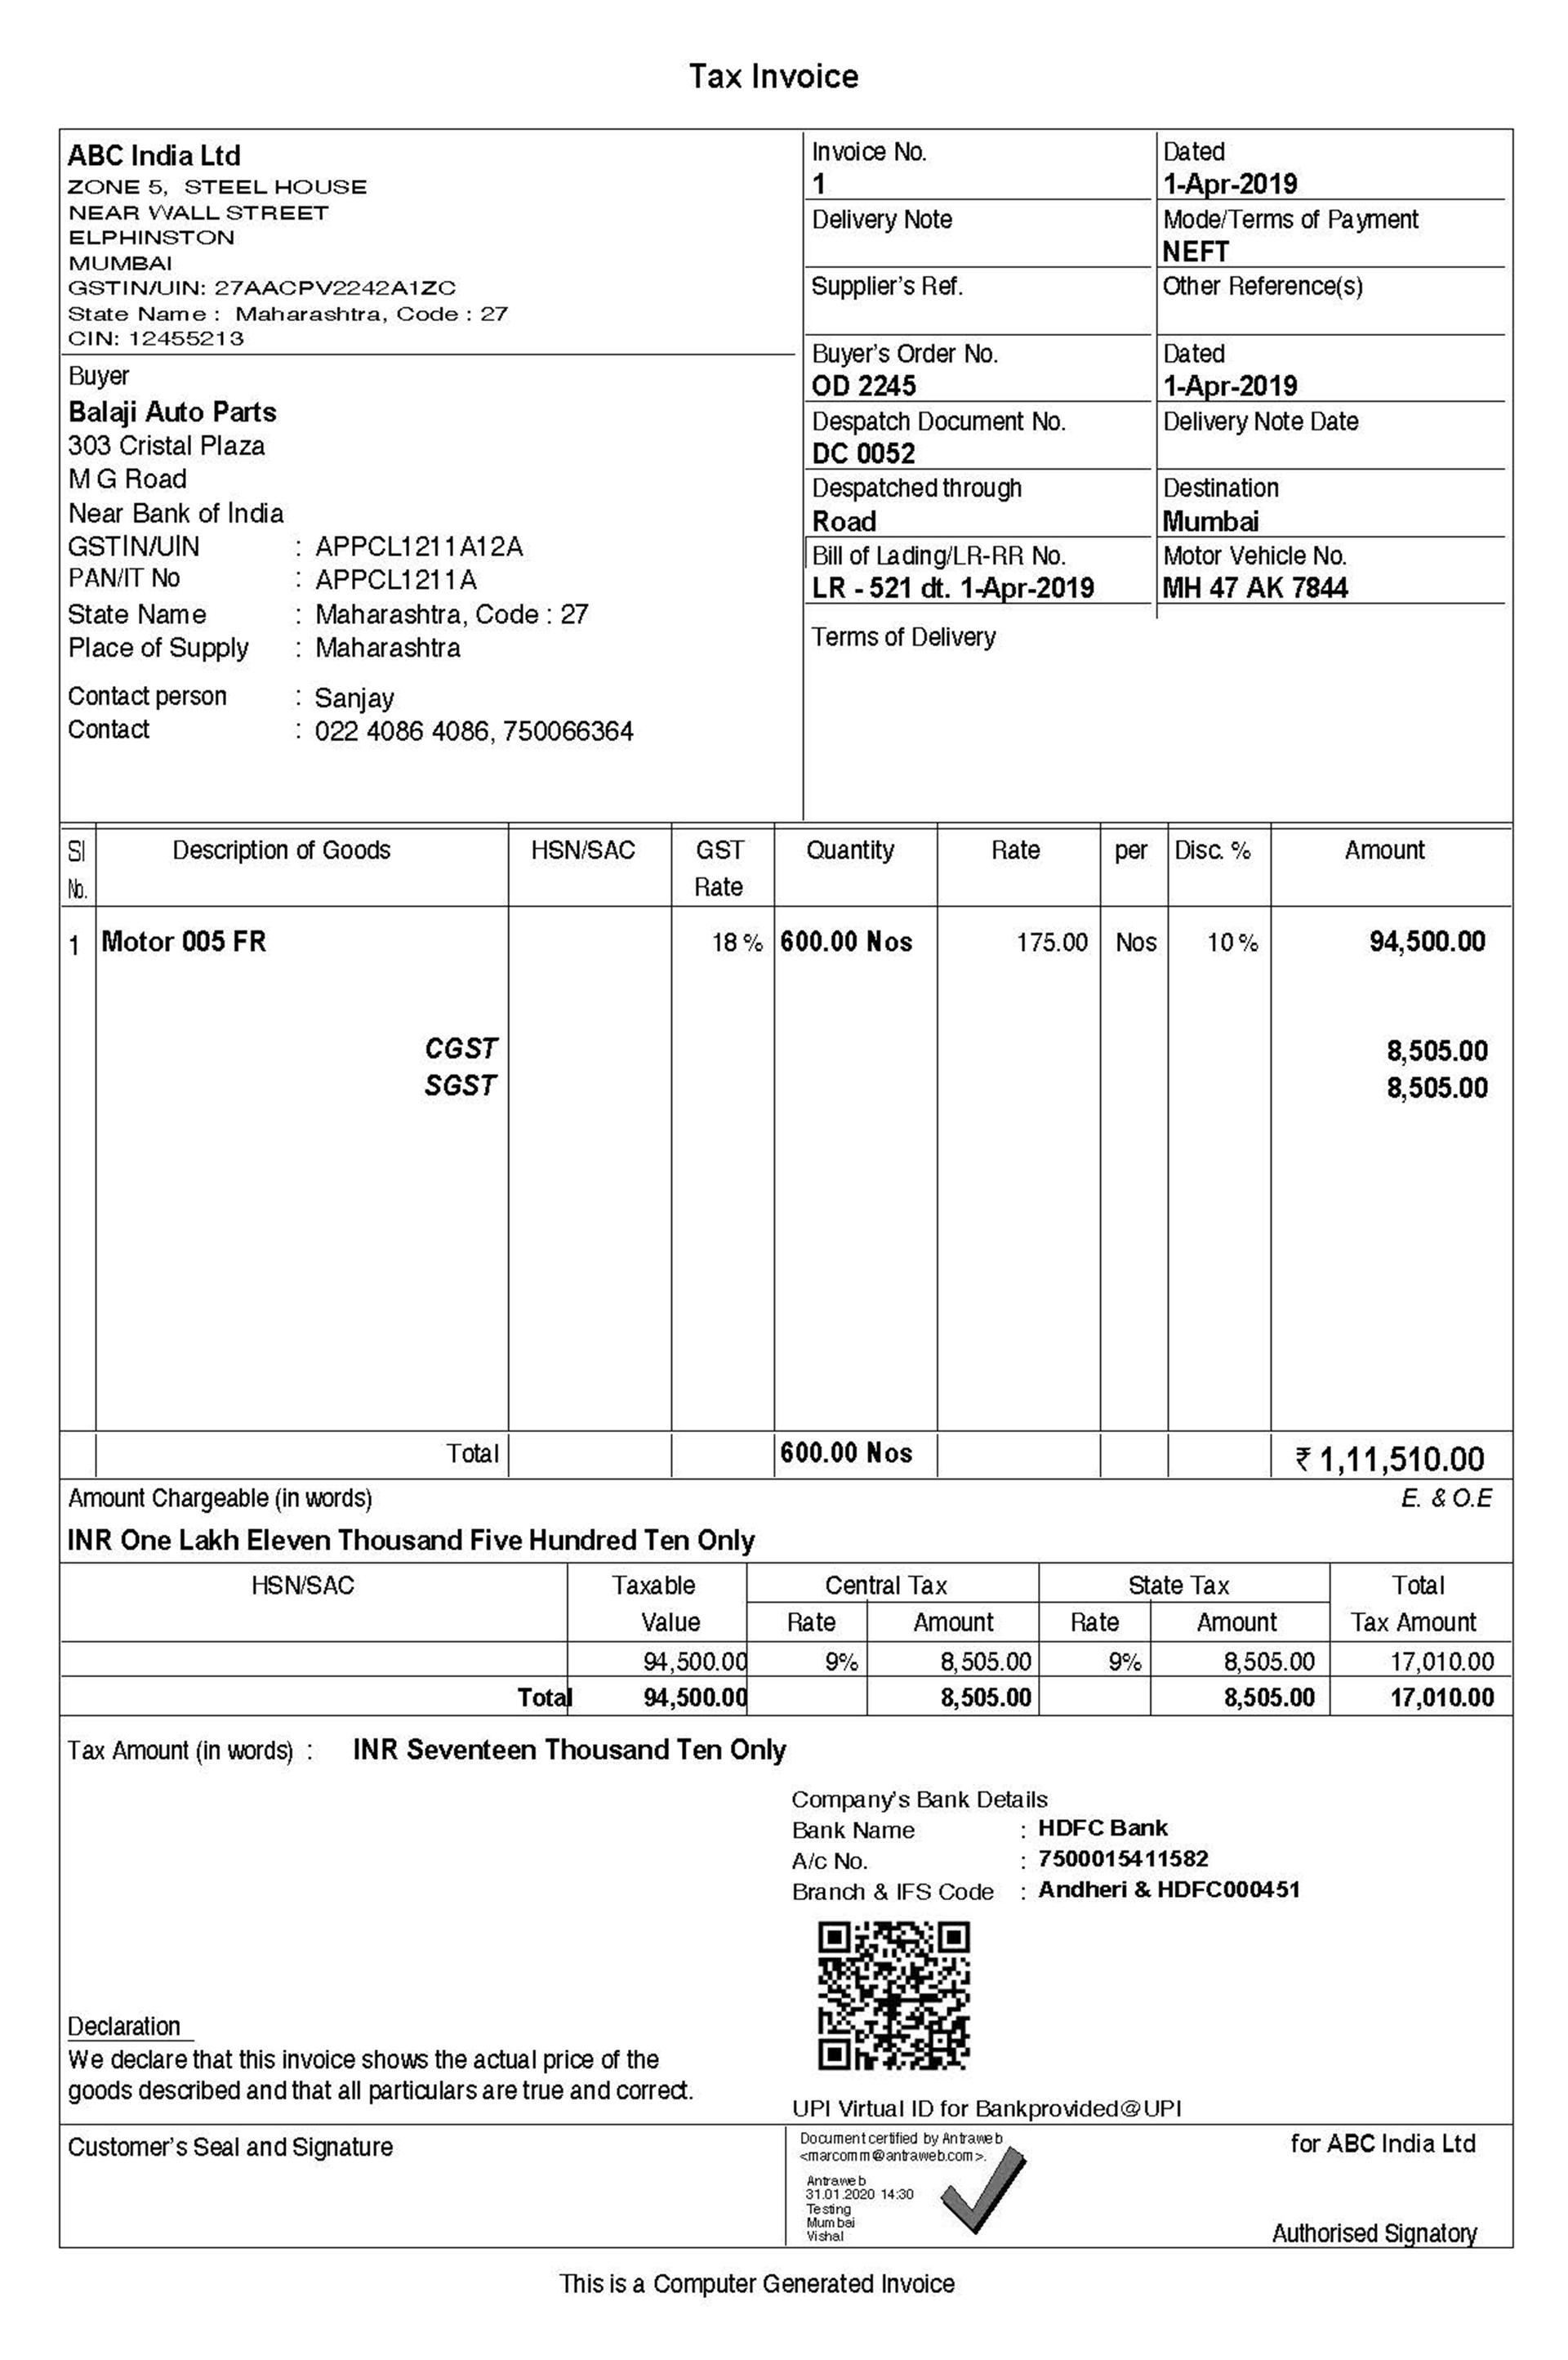


    Image #1:
    Origin: file:/content/Document_budget.png
    Resolution: 143 dpi
    Width: 1598 px
    Height: 1730 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


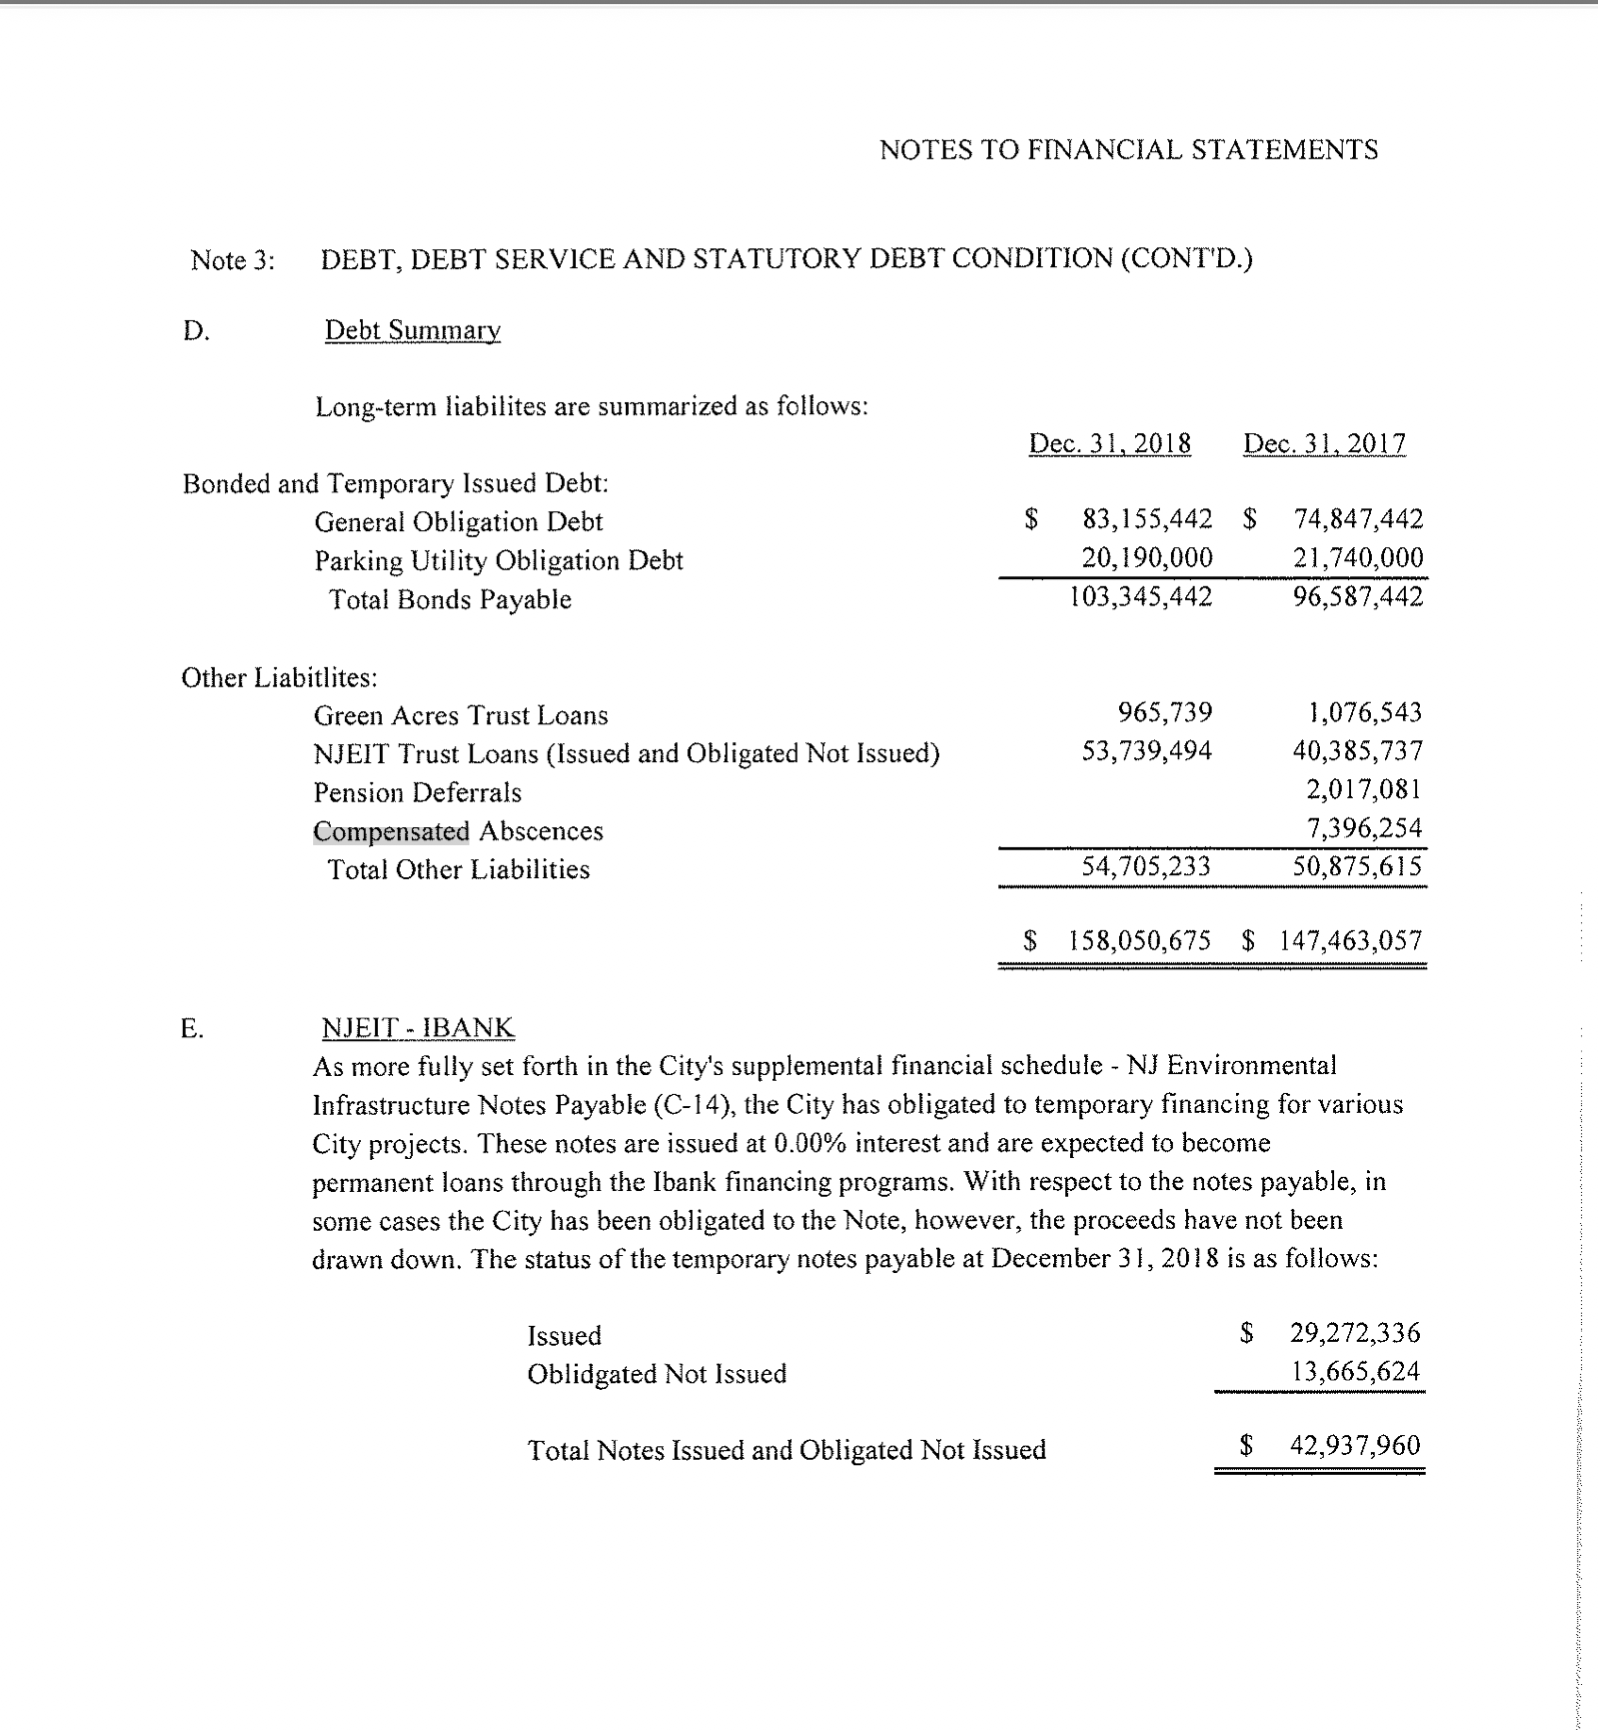


    Image #2:
    Origin: file:/content/Document_advertisement2.png
    Resolution: 0 dpi
    Width: 691 px
    Height: 691 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


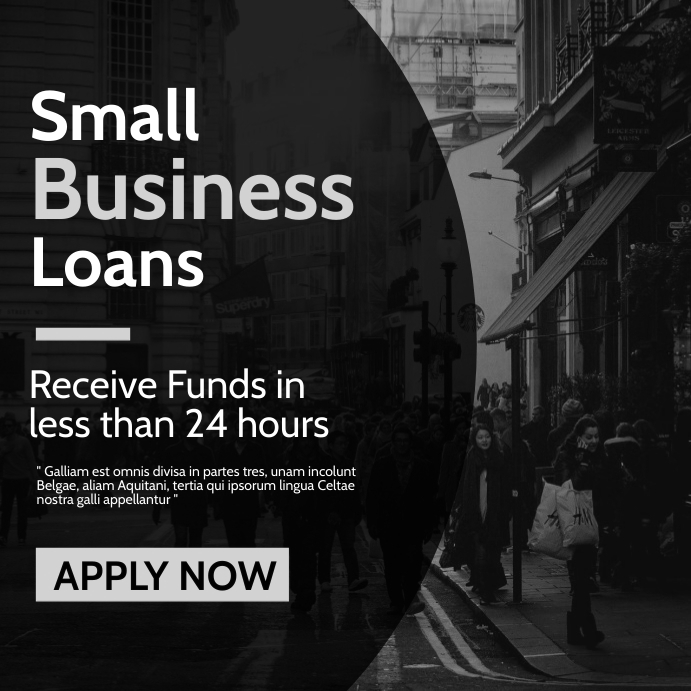

In [33]:
image_df = BinaryToImage().transform(sample_images)
display_images(image_df)

# Define pipeline

In [34]:
from sparkocr.utils import get_vocabulary_dict

binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

doc_class = VisualDocumentClassifierV3() \
    .pretrained("dit_base_finetuned_rvlcdip", "en", "clinical/ocr") \
    .setInputCols(["image"])\
    .setOutputCol("label")

pipeline = PipelineModel(stages=[binary_to_image,
                                 doc_class])

# Call pipeline

In [35]:
results = pipeline.transform(sample_images).cache()

# Show results

In [36]:
results

image,path,modificationTime,length,pagenum,label,exception
{file:/content/Do...,file:/content/Doc...,2022-08-26 03:35:...,1364836,0,invoice,null
{file:/content/Do...,file:/content/Doc...,2022-08-26 03:27:...,1166870,0,budget,null
{file:/content/Do...,file:/content/Doc...,2022-08-26 03:35:...,305933,0,advertisement,null
